<a href="https://colab.research.google.com/github/ibe16/ducktectron2/blob/master/Introduction_to_Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

# Introduction to Detectron2

Based on the original [Detectron2 Beginner's Tutorial](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5), the aim of this notebook is to explore how to run inference with an existing model and try the different detection algorithms.

Detectron2 includes:
*   Object detection
*   DensePose
*   Panoptic segmentation
*   Person Keypoint Detection


Let's get started!!


# Installation

If you are on Google Colab you may need to enable GPU usage. Please check it on Runtime > Change runtime type.

In [0]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

In [0]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Run a pre-trained model

Let's try different models for several usages.

We first download a few ramdom images from internet.

In [0]:
!wget https://vignette.wikia.nocookie.net/futbol/images/e/e9/Cr7.jpg/revision/latest/top-crop/width/360/height/450?cb=20190806210828 -O input_0.jpg
!wget https://images.pushsquare.com/94a465348a734/the-witcher-netflix-roach.original.jpg -O input_1.jpg

images = []
for i in range(2):
    im = cv2.imread(f'./input_{i}.jpg')
    images.append(im)

print(images)

--2020-06-01 00:59:49--  https://vignette.wikia.nocookie.net/futbol/images/e/e9/Cr7.jpg/revision/latest/top-crop/width/360/height/450?cb=20190806210828
Resolving vignette.wikia.nocookie.net (vignette.wikia.nocookie.net)... 74.120.188.204, 74.120.188.194
Connecting to vignette.wikia.nocookie.net (vignette.wikia.nocookie.net)|74.120.188.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31484 (31K) [image/jpeg]
Saving to: ‘input_0.jpg’

input_0.jpg         100%[===================>]  30.75K  --.-KB/s    in 0.007s  

2020-06-01 00:59:49 (4.07 MB/s) - ‘input_0.jpg’ saved [31484/31484]

--2020-06-01 00:59:51--  https://images.pushsquare.com/94a465348a734/the-witcher-netflix-roach.original.jpg
Resolving images.pushsquare.com (images.pushsquare.com)... 104.26.15.246, 104.26.14.246, 2606:4700:20::681a:ef6, ...
Connecting to images.pushsquare.com (images.pushsquare.com)|104.26.15.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115464 (113

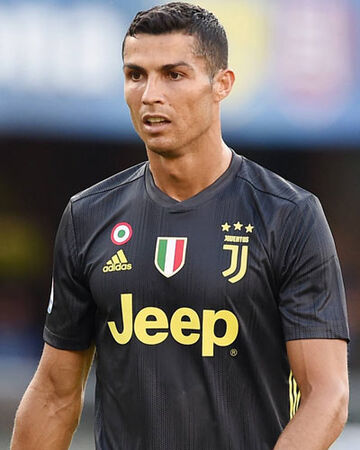

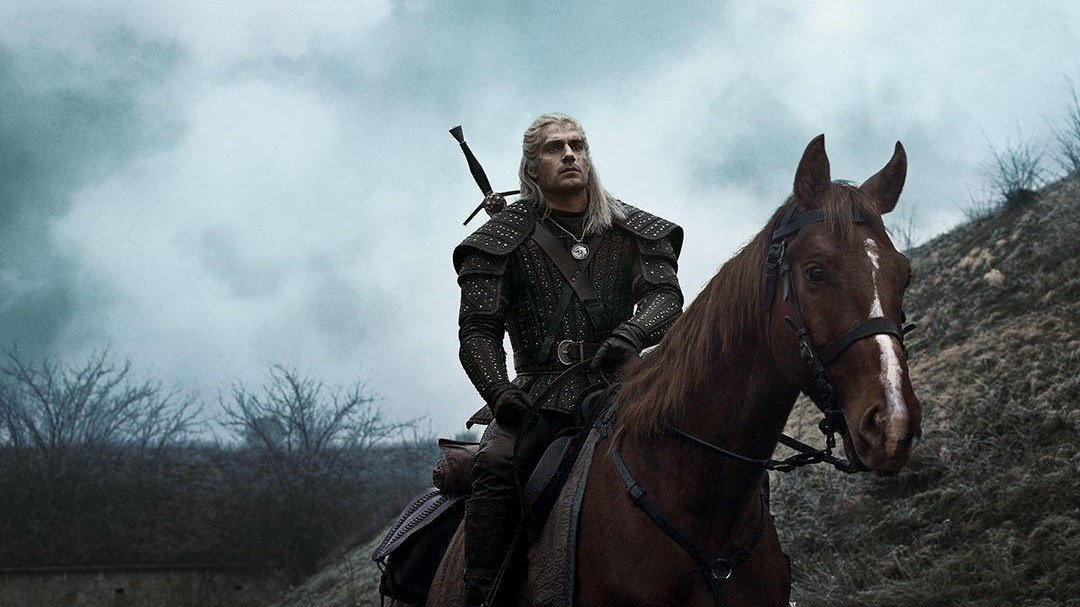

In [0]:
for im in images:
    cv2_imshow(im)

## Detection and Segmentation

Then, we'll create a `DefaultPredictor` to run inference on these images.

The path to the configuration file for the model and the weights is at [MODEL_ZOO.md](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md). Click on the model name. We need the path to the file.

In [0]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

outputs = []
for im in images:
    outputs.append(predictor(im))

model_final_f10217.pkl: 178MB [00:18, 9.63MB/s]                           


Let's see the results. `Visualizer` is used to draw the predictions on the image.

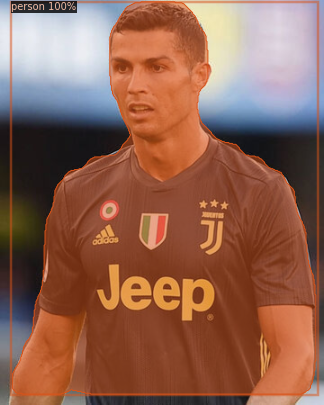

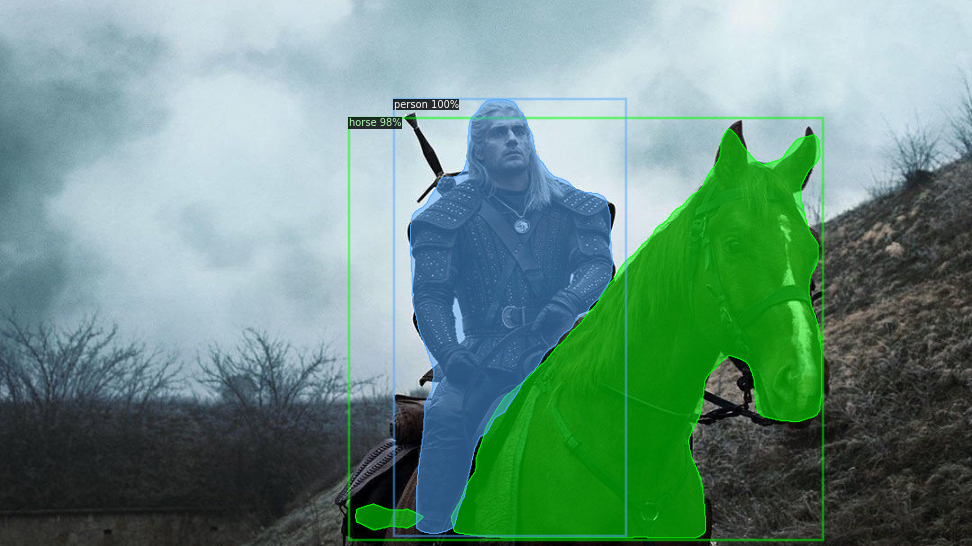

In [0]:
for im, output in zip(images, outputs):
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.9)
    v = v.draw_instance_predictions(output["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

## Keypoint detection

In [0]:
# Inference with a keypoint detection model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

outputs = []
for im in images:
    outputs.append(predictor(im))

model_final_a6e10b.pkl: 237MB [00:24, 9.79MB/s]                           


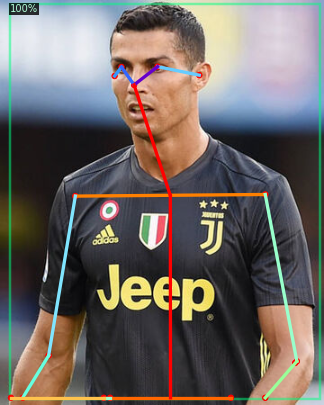

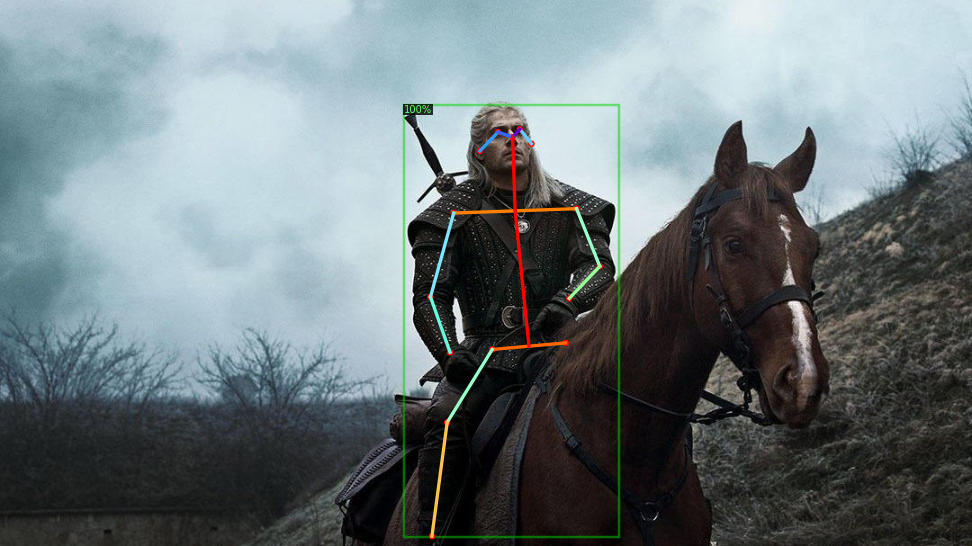

In [0]:
for im, output in zip(images, outputs):
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.9)
    v = v.draw_instance_predictions(output["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

## Panoptic segmentation model



In [0]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)

panoptic_seg=[]
segments_info=[]
for im in images:
    p, s = predictor(im)["panoptic_seg"]
    panoptic_seg.append(p)
    segments_info.append(s)

model_final_cafdb1.pkl: 261MB [00:26, 9.97MB/s]                           


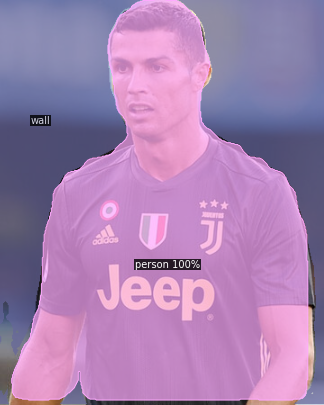

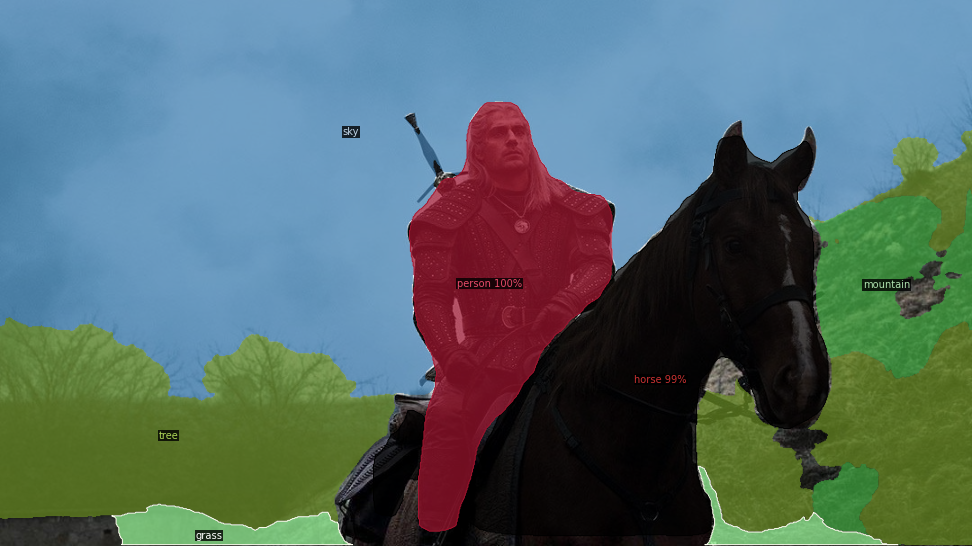

In [0]:
for im, p, s in zip(images, panoptic_seg, segments_info):
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.9)
    v = v.draw_panoptic_seg_predictions(p.to("cpu"), s)
    cv2_imshow(v.get_image()[:, :, ::-1])

# Keypoint detection on a video

In the [Detectron2 tutorial](colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5) they run panoptic segmentation on a video. Here we try to run Keypoint detection in the same way.

First we get the video we're going to process

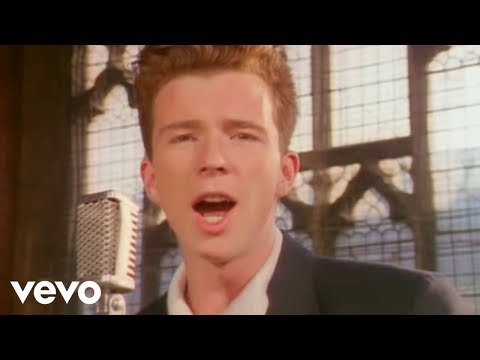

In [0]:
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("dQw4w9WgXcQ", width=500)
display(video)

Next, we'll install dependencies, download the video and crop 10 seconds for processing. 

In [0]:
# Reinstall openvc library. The one pre-installed have some issues 
!pip uninstall -y opencv-python opencv-contrib-python
!apt install python3-opencv 

In [0]:
# Download and crop de video
!pip install youtube-dl
!youtube-dl https://www.youtube.com/watch?v=dQw4w9WgXcQ -f 18 -o video.mp4
!ffmpeg -i video.mp4 -t 00:00:11 -c:v copy video-clip.mp4

In order to run the inference frame-by-frame, the tutorial uses [Detectron2 Demo script](https://github.com/facebookresearch/detectron2/blob/master/GETTING_STARTED.md) on Github, and so do we. This Demo offers a command line tool.

In [0]:
!git clone https://github.com/facebookresearch/detectron2


If you want to use other model, the `model_id/model_final_{commit}.pkl` (this part `137849621/model_final_a6e10b.pkl` for the `MODEL.WEIGHTS` argument) are in the [detectron2/model_zoo/model_zoo.py](https://github.com/facebookresearch/detectron2/blob/master/detectron2/model_zoo/model_zoo.py) file on Github.

In [0]:
!python detectron2/demo/demo.py --config-file detectron2/configs/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml --video-input video-clip.mp4 --confidence-threshold 0.6 --output output.mkv \
  --opts MODEL.WEIGHTS detectron2://COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl

Failed to load OpenCL runtime
[06/01 03:20:57 detectron2]: Arguments: Namespace(confidence_threshold=0.6, config_file='detectron2/configs/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml', input=None, opts=['MODEL.WEIGHTS', 'detectron2://COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl'], output='output.mkv', video_input='video-clip.mp4', webcam=False)
[06/01 03:21:01 fvcore.common.checkpoint]: Loading checkpoint from detectron2://COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl
[06/01 03:21:01 fvcore.common.file_io]: URL https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl cached in /root/.torch/fvcore_cache/detectron2/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl
[06/01 03:21:02 fvcore.common.checkpoint]: Reading a file from 'Detectron2 Model Zoo'
100% 275/275 [00:54<00:00,  5.08it/s]


In [0]:
# Download the results
from google.colab import files
files.download('output.mkv')